In [ ]:
import yaml
import torch
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings; warnings.filterwarnings("ignore")

from model.hypernet import Phi, my_trajectory
from model.backbone import Theta
from utils import Config
from utils import wasserstein, Config, jensen_shannon, calculate_mmd

In [2]:
system = 'epidemic'
device = 'cuda:0'

DEVICE = torch.device(device if torch.cuda.is_available() else "cpu")    
with open(f'config/{system}.yaml', 'r') as f:
    config_dict = yaml.safe_load(f)
conf = Config(config_dict)

In [3]:
# --- 1. Prepare Environment & Data ---
interval = conf.interval
horizon_max = int(conf.traj_length/interval)
prefix = f'log'
log_dir = f'{prefix}/{system}/s{interval}/ours/{conf.Theta_model}/NeuralODE' if conf.Phi.dynamics_type == 'NeuralODE' else f'{prefix}/{system}/s{interval}/ours/{conf.Theta_model}/NeuralCDE_{conf.Phi.z_method}'
feature_dir = log_dir + '/theta_path'
traj_path = f'data/{system}/trajectories.npy'
trajectories = np.load(traj_path).astype(np.int64)
max_species_count = np.max(trajectories) + 1
seen_time_points = range(0, trajectories.shape[1], interval)
print(f"System: {system} | Interval: {interval} | Horizon: {horizon_max} | Max Species Count: {max_species_count} | Trajectories Shape: {trajectories.shape} | Z_Method: {conf.Phi.z_method} | Z_Dim: {conf.Phi.z_dim}")
trajectories = torch.from_numpy(trajectories).to(DEVICE)

System: epidemic | Interval: 10 | Horizon: 10 | Max Species Count: 52 | Trajectories Shape: (1000, 101, 3) | Z_Method: AE | Z_Dim: 1


In [4]:
# --- 2. Instantiate Models ---
theta_model = Theta(
    hidden_dim=conf.Theta.hidden_dim, 
    num_heads=conf.Theta.num_heads if conf.Theta_model == 'Transformer' else None,
    num_layers=conf.Theta.num_layers, 
    mode=conf.Theta.mode, 
    max_species_count=max_species_count
).to(DEVICE)

phi_model = Phi(
    theta_model=theta_model, 
    dynamics_type=conf.Phi.dynamics_type, 
    theta_snapshots=None, 
    z_dim=conf.Phi.z_dim, 
    z_method=conf.Phi.z_method, 
    energy_lambda=conf.Phi.energy_lambda,
    hidden_dim=conf.Phi.hidden_dim, 
    layer_num=conf.Phi.layer_num, 
    num_heads=conf.Phi.num_heads, 
    dropout_p=conf.Phi.dropout_p,
    tmp_dir=log_dir+'/train',
).to(DEVICE)
print(f"State Num: {max_species_count}| Theta Size ({conf.Theta_model}): {sum(p.numel() for p in theta_model.parameters() if p.requires_grad)}")

State Num: 52| Theta Size (GRU): 852


# Train

Log files and pretrain weights are provided in *log/*. Skip...

Pre-computing and caching DYNAMIC FEATURES for all time points...


Pre-computing Features: 100%|██████████| 11/11 [00:21<00:00,  1.99s/it]


...Caching complete. Starting main training loop.
Fitting Path | Epoch 10000/10000 | MSE Loss: 0.0002


Total Training Progress: 100%|██████████| 100/100 [33:45<00:00, 20.26s/it, Avg_Weight_L=0.0269]


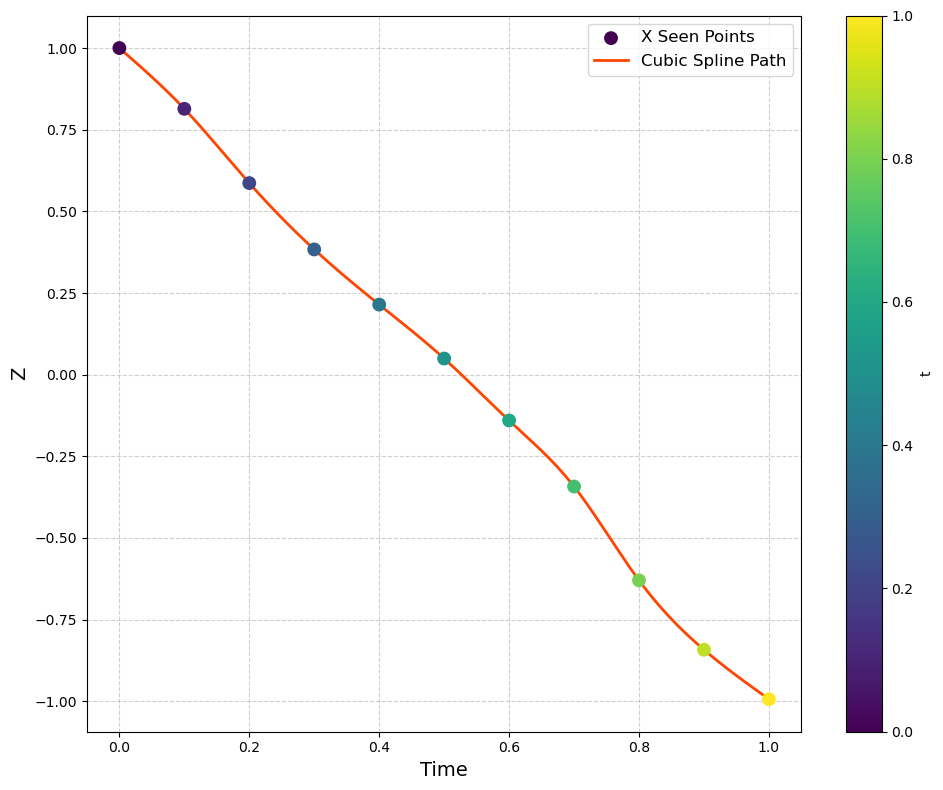

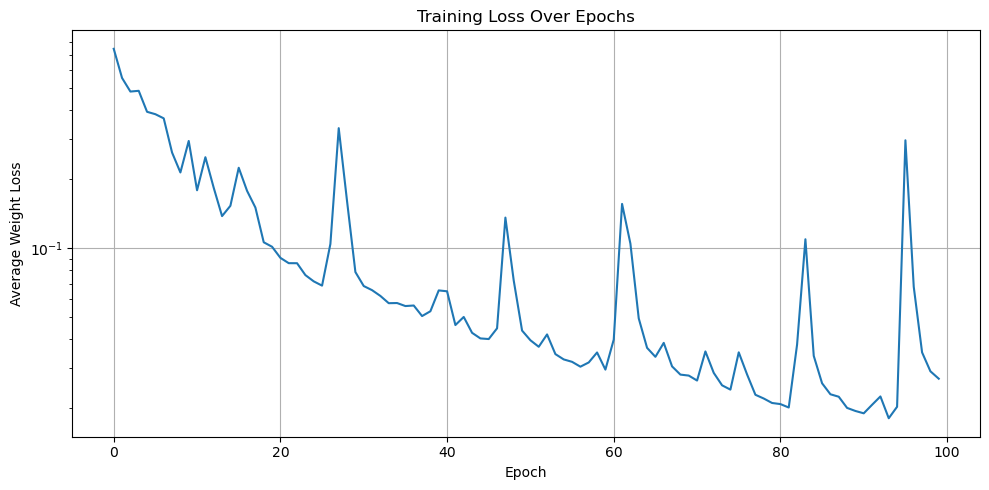

In [ ]:
# # --- 3. Train the Model ---
# phi_model.fit(
#     trajectories=trajectories,
#     seen_time_points=seen_time_points,
#     batch_size=conf.train.batch_size,
#     lr=conf.train.lr,
#     horizon_min=1,
#     horizon_max=horizon_max,
#     total_epochs=conf.train.max_epoch,
#     log_dir=log_dir+'/train',
#     feature_dir=feature_dir,
#     fit_steps=conf.pretrain.fit_steps,
#     verbose=False
# )

# Test

In [6]:
if conf.Phi.dynamics_type == 'NeuralCDE':
    with open(f'{log_dir}/train/phi_path.pkl', 'rb') as f:
        z_path = pickle.load(f)
else:
    z_path = None
    
phi_model = Phi(
    theta_model=theta_model, 
    dynamics_type=conf.Phi.dynamics_type, 
    theta_snapshots=z_path, 
    z_dim=conf.Phi.z_dim, 
    z_method=conf.Phi.z_method, 
    hidden_dim=conf.Phi.hidden_dim, 
    layer_num=conf.Phi.layer_num, 
    num_heads=conf.Phi.num_heads, 
    dropout_p=conf.Phi.dropout_p,
).to(DEVICE)

weight_path = f'{log_dir}/train/phi.pth'
phi_model.dynamics_net.load_state_dict(torch.load(weight_path, map_location=DEVICE))
phi_model.eval()

print(f'Phi size: {sum(p.numel() for p in phi_model.parameters() if p.requires_grad)}')

Phi size: 232397


In [7]:
print("\nStep 1: Get initial state y(0) and static graph structure...") 
y0 = torch.load(feature_dir + '/feat_t0.pt', map_location=DEVICE)
graph_data_template = phi_model.theta.get_weight_graph()


Step 1: Get initial state y(0) and static graph structure...


In [8]:
print("\nStep 2: Starting long-term prediction, sampling, and evaluation...")
# Evolve the initial state y0 across all future time points at once
dataset = my_trajectory(trajectories, device=DEVICE)
test_time_points = range(0, dataset.time_length)
with torch.no_grad():
    t_span = torch.tensor(test_time_points, device=DEVICE).float() / dataset.time_length  # Normalize time span to [0, 1]
    y_pred_sequence = phi_model.forward(y0.unsqueeze(0), t_span)
    y_pred_sequence = y_pred_sequence.squeeze(1)


Step 2: Starting long-term prediction, sampling, and evaluation...


In [9]:
print("\nStep 3: Evaluating Metrics at each predicted time point...")
# Iterate through the PREDICTED sequence to evaluate
pbar = tqdm(enumerate(test_time_points[1:]), desc="Evaluating Predictions", total=len(test_time_points) - 1)
avg_w1_t = []
avg_w2_t = []
jsd_t = []
true_samples, pred_samples = [], []
for idx, abs_t in pbar:
    y_pred_at_t = y_pred_sequence[idx]
    
    # Reconstruct the theta model from the predicted dynamic state for this time step
    graph_data_for_loading = graph_data_template.copy()
    graph_data_for_loading['tokens'] = y_pred_at_t
    phi_model.theta.load_weight_graph(graph_data_for_loading)
    
    # Ground truth data at this time step
    actual_samples = dataset[abs_t]
    
    # Sample from the reconstructed model
    predicted_samples = phi_model.theta.sample(
        num_samples=actual_samples.shape[0],
        num_species=dataset.num_species
    )
    
    random_idx = np.random.choice(actual_samples.shape[0], 1000, replace=False)
    true_samples.append(actual_samples.detach().cpu().numpy()[random_idx])
    pred_samples.append(predicted_samples.detach().cpu().numpy()[random_idx])

    # convert to one-hot encoding for the next state
    gene_states = theta_model.max_species_count.item()
    actual_samples_dist = torch.eye(gene_states).to(DEVICE)[actual_samples]
    predicted_samples_dist = torch.eye(gene_states).to(DEVICE)[predicted_samples]
    
    predicted_samples_dist = predicted_samples_dist.mean(dim=0)
    actual_samples_dist = actual_samples_dist.mean(dim=0)
    avg_w1, avg_w2 = wasserstein(predicted_samples_dist, actual_samples_dist)
    jsd = jensen_shannon(predicted_samples_dist, actual_samples_dist)
    
    pbar.set_postfix({'t': abs_t, 'W1': f'{avg_w1:.4f}', 'W2': f'{avg_w2:.4f}', 'JSD': f'{jsd:.4f}'})
        
    jsd_t.append(jsd)
    avg_w1_t.append(avg_w1)
    avg_w2_t.append(avg_w2)


Step 3: Evaluating Metrics at each predicted time point...


Evaluating Predictions: 100%|██████████| 100/100 [00:00<00:00, 253.76it/s, t=100, W1=0.0745, W2=0.0756, JSD=0.0107]


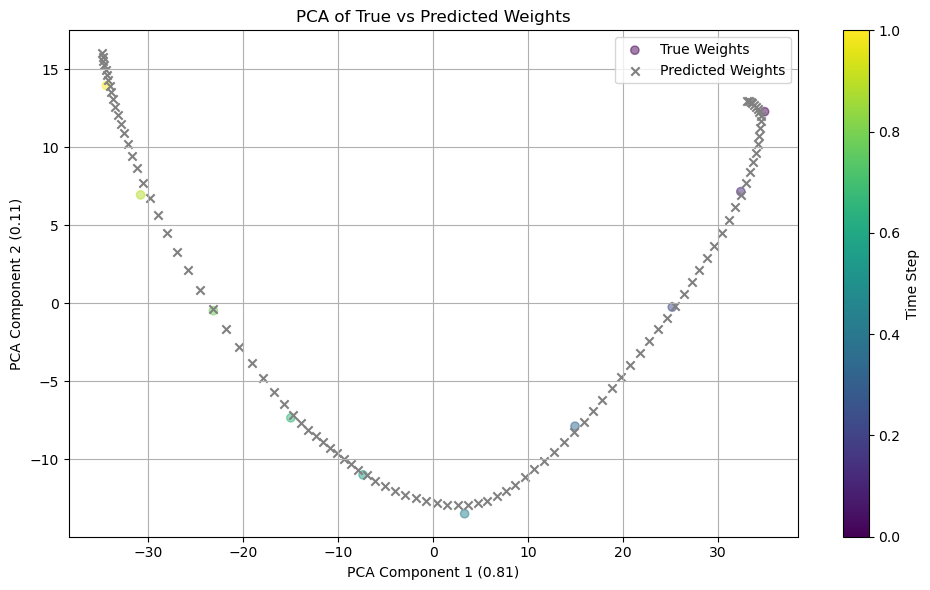

In [10]:
weight_pred = np.array([y_pred_sequence[i-1].cpu().numpy() for i in test_time_points[1:]])
weight_pred_seen = np.array([y_pred_sequence[i-1].cpu().numpy() for i in seen_time_points[1:]])
weight_true = np.array([torch.load(f'{feature_dir}/feat_t{t_idx}.pt', map_location=DEVICE).cpu().numpy() for t_idx in seen_time_points[1:]])
pca = PCA(n_components=2)
weight_true_pca = pca.fit_transform(weight_true.reshape(weight_true.shape[0], -1))
weight_pred_pca = pca.transform(weight_pred.reshape(weight_pred.shape[0], -1))
tspan = np.arange(len(weight_true_pca))
plt.figure(figsize=(10, 6))
plt.scatter(weight_true_pca[:, 0], weight_true_pca[:, 1], label='True Weights', alpha=0.5, c=tspan, cmap='viridis')
plt.scatter(weight_pred_pca[:, 0], weight_pred_pca[:, 1], label='Predicted Weights', color='gray', marker='x')
plt.title('PCA of True vs Predicted Weights')
plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.2f})')
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.2f})')
plt.colorbar(label='Time Step')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(log_dir + f"/weights_path.png", dpi=300)

In [11]:
# --- Result reporting ---
print("\n--- Testing Finished ---")
avg_total_w1 = np.mean(avg_w1_t)
avg_total_w2 = np.mean(avg_w2_t)
print(f"\nOverall Average Wasserstein-1: {avg_total_w1:.4f}, Wasserstein-2: {avg_total_w2:.4f}, JSD/MMD: {np.mean(jsd_t):.4f}")


--- Testing Finished ---

Overall Average Wasserstein-1: 0.1157, Wasserstein-2: 0.1214, JSD/MMD: 0.0368
